In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## EWMA

### Exponential Moving Average
Simple Moving Average (SMA) time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. For datasets that contain rapid trend shifts, a SMA may simply be too slow to be useful. 

**Exponential Moving Average (EMA)** helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

### EMA<sub>*t*</sub> = α ∗ (*t*<sub>0</sub> − EMA<sub>*t−1*</sub>) + EMA<sub>*t−1*</sub>

Where:

- t<sub>0</sub> = Latest value
- t<sub>−1</sub> = Previous value
- EMA<sub>*t−1*</sub> = Exponential moving average of previous day.
- The multiplier: α = 2/(M+1)

and 

- M = Number of time periods, span of the window

However, we will use the pandas `ewm()` (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days.

## Bollinger Bands

In [3]:
# Data + Prep from TS: explore lesson
# setting up some matplotlib defaults
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

# making a calculation to convert C to F
# T(°F) = T(K) × 9/5 - 459.67
def to_fahrenheit(k):
    return k * 9/5 - 459.67

In [4]:
url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
# reading in our csv, pulling out temp specifically (single series)
s = pd.read_csv(url, index_col='datetime', parse_dates=True).temp
# dropping out nulls
s = s.dropna()
# applying our to_fahrenheit
s = to_fahrenheit(s)
# resample to Day
s = s.resample('D').mean()

In [5]:
s

datetime
2012-10-01    61.330942
2012-10-02    65.678822
2012-10-03    67.411250
2012-10-04    67.703750
2012-10-05    77.073125
                ...    
2017-11-26    65.744750
2017-11-27    62.474750
2017-11-28    63.802775
2017-11-29    64.580000
2017-11-30    65.966000
Freq: D, Name: temp, Length: 1887, dtype: float64

## Bollinger Bands

- A volatility indicator commonly used in fiscal and trading analysis.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
- Based on the exponential moving average

### Midband

The Exponential Moving Average

`midband = train.ewm(span=30).mean()`

### Upper & Lower Band

UB/LB = Midband +/- stdev * K

`stdev = train.ewm(span=30).std()`

K = the number of standard deviations to go up and down from the EMA

### %b, Percent Bandwidth

Shows where the last value sits in relation to the bands.

%b = last−LB / UB-LB

- If %b > 1, data point lies above the upper band
- If %b < 0, data point lies below the lower band
- If %b == .5, data point lies on the midband.

In [6]:
# K is going to be how many standard deviations out to go
K = 2
# M is our span, or how our window for moving average is defined
M = 20
# old way of doing a standard deviation:
# std = s.rolling(M).std()

In [10]:
# exponential way to call the standard deviation:
std = s.ewm(span=M).std()

In [12]:
bands = pd.DataFrame()

In [13]:
# bands['mid'] = s.rolling(M).mean()
bands['mid'] = s.ewm(span=M).mean()

In [14]:
# calculate upper and lower bands: mid band + K*std for upper, mid - K*std for lower
bands['upper'] = bands['mid'] + K * std
bands['lower'] = bands['mid'] - K * std
bands['actual'] = s

In [15]:
# narrow down scope to 2013 for visualization's sake
t = bands.loc['2013']

In [17]:
# note first instance of upper and lower band will not have a 
# spot for standard deviation with only one observation
bands.head(2)

,mid,upper,lower,actual
datetime,,,,
2012-10-01,61.330942,NaN,NaN,61.330942
2012-10-02,63.613579,69.76241,57.464748,65.678822


In [18]:
t.head(2)

,mid,upper,lower,actual
datetime,,,,
2013-01-01,52.122325,72.793428,31.451222,53.23175
2013-01-02,52.436153,72.198119,32.674188,55.41725


Text(0.5, 0, '')

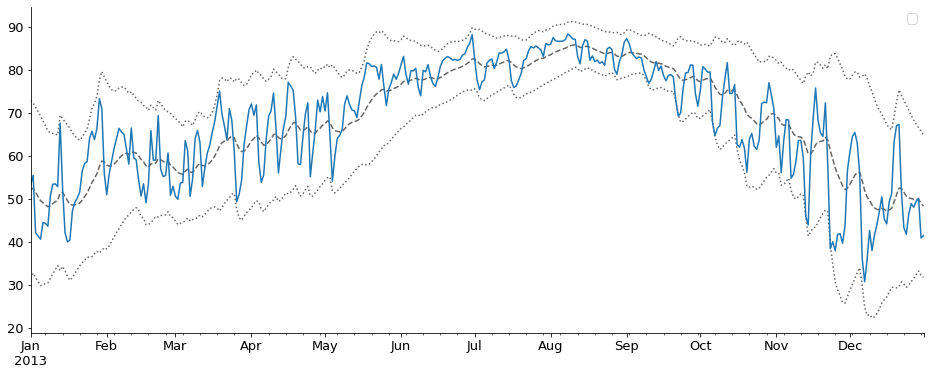

In [19]:
t[['upper', 'lower']].plot(color='black', alpha=.6, ls=':', figsize=(16, 6))
t.mid.plot(color='black', alpha=.6, ls='--')
t.actual.plot()
plt.legend('')
plt.xlabel('')

In [20]:
bands['%b'] = (bands.actual - bands.lower) / (bands.upper - bands.lower)

In [21]:
bands.head(2)

,mid,upper,lower,actual,%b
datetime,,,,,
2012-10-01,61.330942,NaN,NaN,61.330942,NaN
2012-10-02,63.613579,69.76241,57.464748,65.678822,0.667938


In [22]:
upper_outliers = bands[bands['%b'] > 1]

In [23]:
lower_outliers = bands[bands['%b'] < 0]

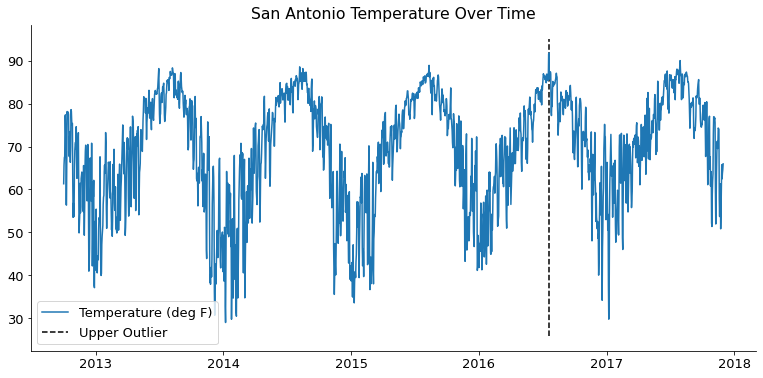

In [24]:
plt.plot(bands.index, bands.actual, label='Temperature (deg F)')
plt.vlines(upper_outliers.index, *plt.ylim(), color='black', ls='--', label='Upper Outlier')
plt.title('San Antonio Temperature Over Time')
plt.legend()

In [25]:
upper_outliers

,mid,upper,lower,actual,%b
datetime,,,,,
2016-07-19,85.774271,91.456434,80.092109,91.5584,1.008972


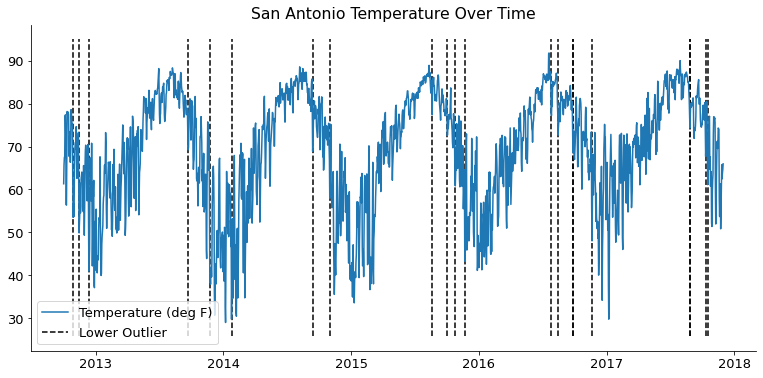

In [26]:
plt.plot(bands.index, bands.actual, label='Temperature (deg F)')
plt.vlines(lower_outliers.index, *plt.ylim(), color='black', ls='--', label='Lower Outlier')
plt.title('San Antonio Temperature Over Time')
plt.legend()

In [27]:
lower_outliers

,mid,upper,lower,actual,%b
datetime,,,,,
2012-10-28,70.299231,86.785959,53.812503,53.507000,-0.009265
2012-11-14,65.981973,82.057873,49.906074,49.877750,-0.000881
2012-12-12,60.734157,79.252416,42.215899,40.967750,-0.033700
2013-09-22,78.547526,87.458451,69.636602,69.220092,-0.023371
2013-11-23,61.223203,83.137358,39.309048,38.414750,-0.020405
2014-01-24,50.405180,70.600301,30.210060,29.765366,-0.011010
2014-09-13,81.403521,91.319519,71.487523,68.910837,-0.129926
2014-11-01,71.061278,82.538814,59.583742,57.957762,-0.070833
2015-08-21,84.413051,90.551047,78.275054,77.423000,-0.069408


(15706.0, 16071.0)

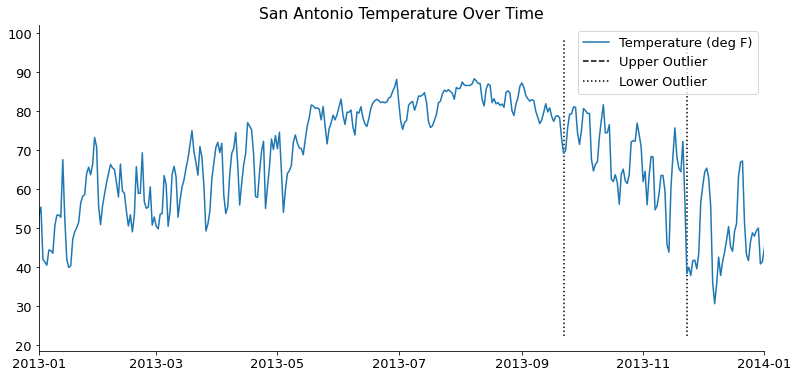

In [28]:
plt.plot(bands.index, bands.actual, label='Temperature (deg F)')
plt.vlines(upper_outliers.index, *plt.ylim(), color='black', ls='--', label='Upper Outlier')
plt.vlines(lower_outliers.index, *plt.ylim(), color='black', ls=':', label='Lower Outlier')
plt.title('San Antonio Temperature Over Time')
plt.legend()
plt.xlim(pd.to_datetime('2013'), pd.to_datetime('2014'))

How do we deal with "dense" data? Use less data points:

- consider a broader resampling period
- use a subset of the data ("zoom in")
- change the threshold for outlier detection -- in this case, use a higher K value
- experiment and iterate

"If you torture the data enough it will confess to anything"

- Is this analysis reproducible with new data?
- If my worst enemy read this work, what would they criticize?
- State your hypothesis, biases, and assumptions ahead of time

## So how do we apply this to the project we are working on?

- data that is not uniformly frequent
- data that has lots of discrete features

A: We create a continuous variable from the discrete ones by resampling + .size().

In [29]:
import env

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = 'SELECT * FROM logs'

df = pd.read_sql(query, url)

In [30]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


I'm choosing to focus on cohort_id

In [31]:
# subset
df = df[df.cohort_id.isin([33, 34, 51])]

In [32]:
# set datetime index, combine date and time columns
df = df.set_index(pd.to_datetime(df.date + ' ' + df.time))

In [33]:
df.head(2)

,date,time,path,user_id,cohort_id,ip
2019-07-15 15:39:34,2019-07-15,15:39:34,/,433,33.0,97.105.19.58
2019-07-15 15:39:48,2019-07-15,15:39:48,toc,433,33.0,97.105.19.58


This is the **secret sauce**

1. groupby + resample + `.size()` gives us counts over time for each unique value of the discrete variable
1. `.unstack(0)` converts the index of the discrete variable to columns

We end up with a dataframe where the rows are our chosen time period, columns are unique values of the discrete var, and the values are the number of times that combination of discrete var + time period shows up (i.e. # of requests per cohort per week).

In [34]:
cohort_requests = df.groupby('cohort_id').resample('W').size()

In [37]:
cohort_requests = cohort_requests.unstack(0)

<AxesSubplot:>

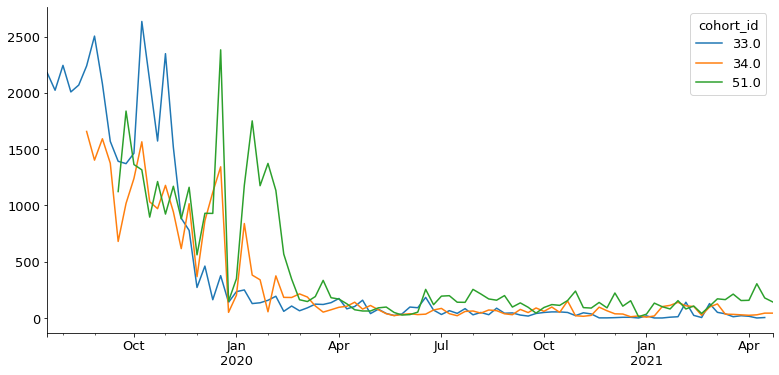

In [38]:
cohort_requests.plot()

In [39]:
K = 2
M = 5

In [42]:
cohort_requests.head(5)

cohort_id,33.0,34.0,51.0
2019-07-21,2178.0,NaN,NaN
2019-07-28,2023.0,NaN,NaN
2019-08-04,2244.0,NaN,NaN
2019-08-11,2008.0,NaN,NaN
2019-08-18,2069.0,NaN,NaN


In [45]:
s = cohort_requests.iloc[:,0]

In [46]:
s

2019-07-21    2178.0
2019-07-28    2023.0
2019-08-04    2244.0
2019-08-11    2008.0
2019-08-18    2069.0
               ...  
2021-03-28      20.0
2021-04-04      15.0
2021-04-11       0.0
2021-04-18       4.0
2021-04-25       NaN
Name: 33.0, Length: 93, dtype: float64

In [47]:
bands = pd.DataFrame()
std = s.ewm(span=M).std()
# std = s.rolling(M).std()
bands['actual'] = s

# bands['mid'] = bands.actual.rolling(M).mean()
bands['mid'] = s.ewm(span=M).mean()
bands['upper'] = bands['mid'] + K * std
bands['lower'] = bands['mid'] - K * std
bands.head()

,actual,mid,upper,lower
2019-07-21,2178.0,2178.000000,NaN,NaN
2019-07-28,2023.0,2085.000000,2304.203102,1865.796898
2019-08-04,2244.0,2160.315789,2403.497550,1917.134029
2019-08-11,2008.0,2097.046154,2348.537994,1845.554314
2019-08-18,2069.0,2086.279621,2281.170287,1891.388954


Text(0, 0.5, '# of requests')

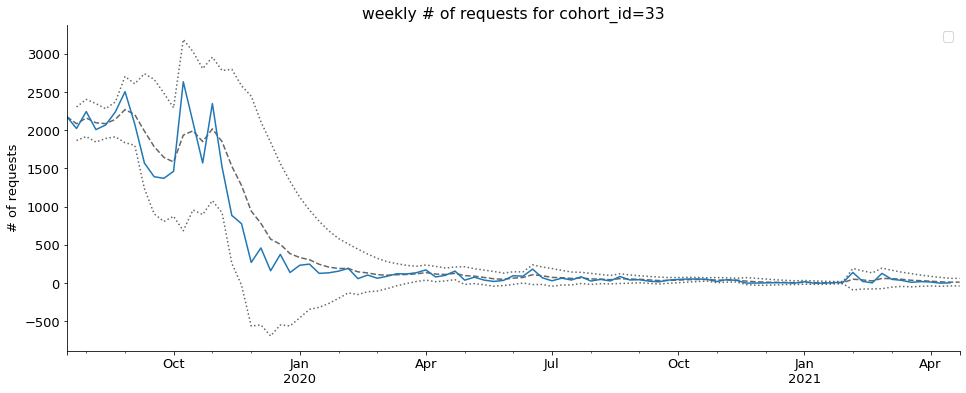

In [48]:
bands[['upper', 'lower']].plot(color='black', alpha=.6, ls=':', figsize=(16, 6))
bands.mid.plot(color='black', alpha=.6, ls='--')
bands.actual.plot()
plt.legend('')
plt.xlabel('')
plt.title('weekly # of requests for cohort_id=33')
plt.ylabel('# of requests')

Next steps:

1. Calculate %b to call out outliers and visualize
1. tweak hyperparams -- try a ewma, diff values for k
1. apply this to multiple cohorts or other discrete variables (a function might help!)